In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [10]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms
from pyEM import plotting
import rw_models
import joblib

In [15]:
modelID = 'RW'
param_names = ['beta', 'lr']
# param_names = ['alpha_rew', 'alpha_pun', 'beta'] # slot version
objfunc_dict = {modelID: rw_models.fit}
simul_dict   = {modelID: rw_models.simulate}

nsubjects = 219
betamin, betamax   = .75,  10
alphamin, alphamax = .05, .95

In [16]:
params = np.ones((nsubjects, 2))
for simS in tqdm(range(nsubjects)):
    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm2beta(norm.rvs(0, scale=1))

    # For alpha, we will sample from a beta distribution and then transform
    params[simS, 1] = beta.rvs(1.1, 1.1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = beta.rvs(1.1, 1.1)

100%|██████████| 219/219 [00:00<00:00, 9267.26it/s]


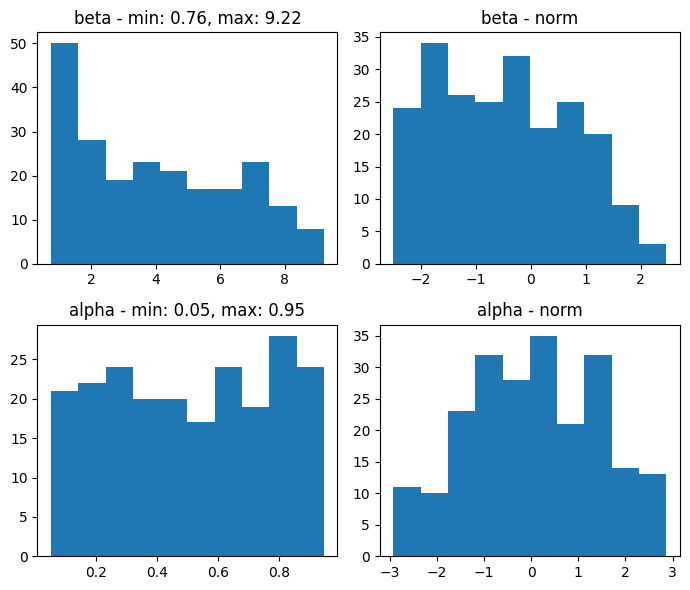

In [13]:
# plot 2 x 2
plt.figure(figsize=(7, 6))
plt.subplot(221)
plt.hist(params[:,0]);
plt.title(f'beta - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(222)
plt.hist(beta2norm(params[:,0]));
plt.title(f'beta - norm');

plt.subplot(223)
plt.hist(params[:,1]);
plt.title(f'alpha - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

plt.subplot(224)
plt.hist(alpha2norm(params[:,1]));
plt.title(f'alpha - norm');

plt.tight_layout()

In [17]:
ntrials, nblocks = 35, 3
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict['RW']
subj_dict = simulfunc(params, nblocks=nblocks, ntrials=ntrials)

ntrials: 35, nblocks: 3


  0%|          | 0/219 [00:00<?, ?it/s]..\pyEM\math.py:9: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(beta*EVs) / np.sum(np.exp(beta*EVs))
  0%|          | 1/219 [00:00<00:03, 62.86it/s]


ValueError: probabilities contain NaN

In [ ]:
plotting.plot_choices(subj_dict['choices_L']) 